In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *

import pandas as pd
#import seaborn as sns

In [2]:
from local_utils import *

In [3]:
df = pd.read_csv("../with_diffusions_second_search/df_network_analysis_full_topology_with_estimates.csv")
df["adj_tup"] = df["adj_tup"].apply(lambda x: eval(f"tuple({x})"))
df["Adj"] = df["adj_tup"].apply(lambda x: np.array(x).reshape((3,3)))

In [4]:
adj=np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
subnet_list = [g[1] for g in df.groupby("adj_tup") if g[0] == tuple(adj.flatten())]
if len(subnet_list) == 0:
    print("================================")
    print("There is no adjacancy matrix as: ", adj)
    print("================================")
else:
    subnet_df = subnet_list[0]

In [5]:
subnet_df.head(1)

,Unnamed: 0,min_A,min_B,min_C,avg_A,avg_B,avg_C,max_A,max_B,max_C,...,b_C_est_ratio,V_C_est_ratio,K_AC_est_ratio,K_BC_est_ratio,K_CC_est_ratio,bad_estimates,list_of_bad_estimates,loss,loss_hat,loss_ratio
0,0,0.879311,27.4671,2.00005,3.859942,31.707845,2.000238,6.759598,35.970982,2.000543,...,0.999996,0.020842,1.013337,2.379039,0.894056,2,"('V_C', 'K_BC')",9.617466e-08,2.276804e-08,0.763264


In [6]:
def load_dataset(path):
    with open(f"../{path}", "rb") as f:
        k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [7]:
def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)

def rmse(arr1, arr2):
    return np.sqrt(np.mean((arr1-arr2)**2))

In [ ]:
with open(f"./temp/simulation_from_start_results_high_resolution_diffusion_ratio.npy", "rb") as f:
    results_from_start_diffusion = np.load(f, allow_pickle=True)
with open(f"./temp/simulation_from_end_results_diffusion.npy", "rb") as f:
    results_from_end_diffusion = np.load(f, allow_pickle=True) 

In [9]:
with open(f"./temp/simulation_from_start_results_high_resolution_diffusion.npy", "rb") as f:
    results_from_start_high_resolution_diffusion = np.load(f, allow_pickle=True)
with open(f"./temp/simulation_from_end_results_high_resolution_diffusion.npy", "rb") as f:
    results_from_end_high_resolution_diffusion = np.load(f, allow_pickle=True)

In [10]:
with open(f"./temp/simulation_from_start_results.npy", "rb") as f:
    results_from_start = np.load(f, allow_pickle=True)
with open(f"./temp/simulation_from_end_results.npy", "rb") as f:
    results_from_end = np.load(f, allow_pickle=True)    

In [11]:
with open(f"./temp/simulation_from_start_results_high_resolution.npy", "rb") as f:
    results_from_start_high_resolution = np.load(f, allow_pickle=True)
with open(f"./temp/simulation_from_end_results_high_resolution.npy", "rb") as f:
    results_from_end_high_resolution = np.load(f, allow_pickle=True)   

In [14]:
with open(f"./temp/simulation_from_start_results_high_resolution_2_2.npy", "rb") as f:
    results_from_start_high_resolution_2 = np.load(f, allow_pickle=True)
with open(f"./temp/simulation_from_end_results_high_resolution_2_2.npy", "rb") as f:
    results_from_end_high_resolution_2 = np.load(f, allow_pickle=True)   

In [15]:
def plot_results(index,
                 from_start=True,
                 noise_level=None,
                 condition=0,
                 hi_resolution=0,
                 diffusion=False):
    noise_map = {0:'no_noise', 1:'1_percent_noise', 2:'2_percent_noise', 5:'5_percent_noise'}
    if hi_resolution == 0:
        hres= ""
    elif hi_resolution == 1:
        hres = "_high_resolution"
    else:
        hres = "_high_resolution_2"
        
    if diffusion:
        d = "_diffusion"
    else:
        d = ""
    if from_start:
        if hi_resolution == 0:
            if diffusion:
                results = results_from_start_diffusion
            else:
                results = results_from_start
        elif hi_resolution == 1:
            if diffusion:
                results = results_from_start_high_resolution_diffusion
            else:
                results = results_from_start_high_resolution
        else:
            results = results_from_start_high_resolution_2
    else:
        if hi_resolution == 0:
            if diffusion:
                results = results_from_end_diffusion
            else:
                results = results_from_end
        elif hi_resolution == 1:
            if diffusion:
                results = results_from_end_high_resolution_diffusion
            else:
                results = results_from_end_high_resolution
        else:
            results = results_from_end_high_resolution_2
            
    
    results = [r for r in results if r[2] == index]
    
    if noise_level is not None:
        results = [r for r in results if r[3] == noise_map[noise_level]]
        
    for result in results:
        if diffusion:
            D_B_val = 1.0
            (simulate_from_start,
             i,
             index, 
             run, 
             path,
             (n_val, 
              D_A_val, #D_B_val,
              b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
              b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
              b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val),
              euclidian_dist,
              c_dist) = result
        else:
            D_A_val, D_B_val = 0.01, 1.0
            (simulate_from_start,
             i,
             index, 
             run, 
             path,
             (n_val, 
              b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
              b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
              b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val),
              euclidian_dist,
              c_dist) = result
        ###############################
        (_, res_1, _) = load_dataset(path)
        with open(f"./temp/res_{index}_{run}_{i}_{0 if simulate_from_start else 1}{hres}{d}.npy", "rb") as f:
            res_2 = np.load(f)
        A1 = res_1[-1, 0, :]
        B1 = res_1[-1, 1, :]
        C1 = res_1[-1, 2, :]
        A2 = res_2[-1, 0, :]
        B2 = res_2[-1, 1, :]
        C2 = res_2[-1, 2, :] 

        def field_amp(arr):
            return np.max(arr) - np.min(arr) 
        
        if condition == 0:
            if ( (field_amp(A2) < 0.90 * field_amp(A1) or field_amp(A2) > 1.1 * field_amp(A1)) or
                 (field_amp(B2) < 0.90 * field_amp(B1) or field_amp(B2) > 1.1 * field_amp(B1)) or
                 (field_amp(C2) < 0.90 * field_amp(C1) or field_amp(C2) > 1.1 * field_amp(C1)) or
                 rmse(A2,A1) > 1.0 or rmse(B2, B1) > 1.0 or rmse(C2,C1) > 1.0
               ):
                continue
        elif condition == 1:
            if ( (field_amp(A2) < 0.90 * field_amp(A1) or field_amp(A2) > 1.1 * field_amp(A1)) or
                 (field_amp(B2) < 0.90 * field_amp(B1) or field_amp(B2) > 1.1 * field_amp(B1)) or
                 (field_amp(C2) < 0.90 * field_amp(C1) or field_amp(C2) > 1.1 * field_amp(C1)) 
               ):
                continue
        elif condition == 2:
            if ( rmse(A2,A1) > 1.0 or rmse(B2, B1) > 1.0 or rmse(C2,C1) > 1.0
               ):
                continue
        elif condition == 3:
            if (np.std(A2 - np.mean(A2)) < 0.05 * np.std(A1 - np.mean(A1)) or
                np.std(B2 - np.mean(B2)) < 0.05 * np.std(B1 - np.mean(B1)) or
                np.std(C2 - np.mean(C2)) < 0.05 * np.std(C1 - np.mean(C1))
               ):
                continue
        elif condition == 4:
            if (np.std(A2 - np.mean(A2)) < 0.05 * np.std(A1 - np.mean(A1)) or
                np.std(B2 - np.mean(B2)) < 0.05 * np.std(B1 - np.mean(B1))
               ):
                continue
        elif condition == 5:
            if (np.std(A2 - np.mean(A2)) < 1e-2 and
                np.std(B2 - np.mean(B2)) < 1e-2
               ):
                continue
        elif condition == 6:
            if (np.max(A2) - np.min(A2) < 1e-2 or
                np.max(B2) - np.min(B2) < 1e-2
               ):                
                continue


      
        print("="*40)
        print(f"{index}-{run}: Minimisation of solution {i+1}")
        print(path)
        print()
        print(np.max(A2) - np.min(A2), np.max(B2) - np.min(B2))
        print(f"D_A:{D_A_val:.4f}, D_B:{D_B_val:.4f}, "
              f"b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
              f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
              f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
              f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
              f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
              f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")  
        print("")
        print(f"Difference norm: {euclidian_dist}")
        print(f"Cos distance   : {c_dist}")
        print("="*40)



        def to(arr):
            return arr.reshape(128, 128)
        plot_n_im([to(A1), to(B1), to(C1)], 
                      ["A1", "B1", "C1"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()


        plot_n_im([to(A2), to(B2), to(C2)], 
                      ["A2", "B2", "C2"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()

        plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
                      ["diff A", "diff B", "diff C"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()
        def RMSE(a1, a2):
            return np.sqrt(np.mean((a1-a2)**2, axis=1))
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
        plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
        plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

        plt.subplot(132)
        plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
        plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
        plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

        steps = 5        
        plt.subplot(133)

        plt.plot(RMSE(res_1[:, 0, :], res_2[::steps, 0, :]) , label="A rmse")
        plt.plot(RMSE(res_1[:, 1, :], res_2[::steps, 1, :]) , label="B rmse")
        plt.plot(RMSE(res_1[:, 2, :], res_2[::steps, 2, :]) , label="C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
        plt.show()


In [ ]:
# 2,9,12, 21, 23, 38, 73 needs improvment

# 10, 69, 73 compeletly estimated for higher resolution

In [144]:
[0, 1, 2, 5, 9, 10, 12, 21, 23, 29, 37, 38, 39, 40, 44, 56, 62, 69, 73, 84]

[0, 1, 2, 5, 9, 10, 12, 21, 23, 29, 37, 38, 39, 40, 44, 56, 62, 69, 73, 84]

In [38]:
plot_results(62, from_start=True, noise_level=0, condition=1, hi_resolution=1)

In [ ]:
plot_results(23, from_start=True, noise_level=0, condition=3, hi_resolution=1)

In [ ]:
plot_results(73, from_start=True, noise_level=5, condition=0, hi_resolution=2)

73-2_percent_noise: Minimisation of solution 3
outputs_second_search/solution_10_9_38.npy

2.235506097664871 38.02987564728406
D_A:0.1120, D_B:1.0000, b_A:0.0899, mu_A:0.5000, V_A:23.0585, K_AA:1.5348, K_AB:0.5095, K_AC:1.4349, b_B:0.9071, mu_B:1.0000, V_B:49.8896, K_BA:28.1163, K_BC:26.1593, b_C:0.0990, mu_C:0.5000, V_C:39.5808, K_CB:22.9084, K_CC:2.0481

Difference norm: 35.90100700560168
Cos distance   : 0.9067693452764108


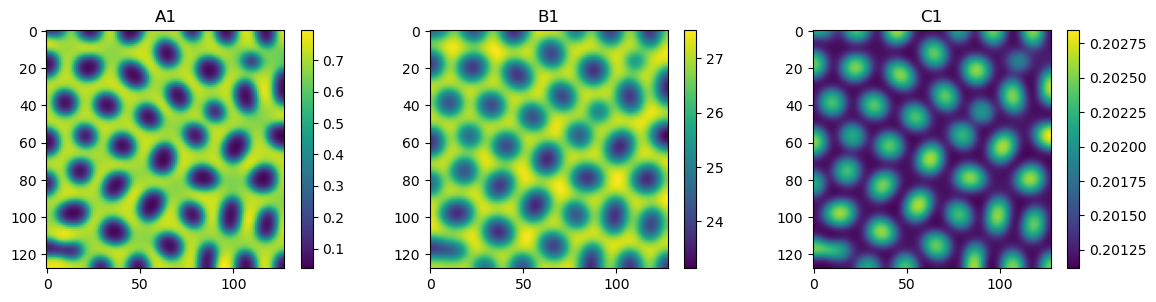

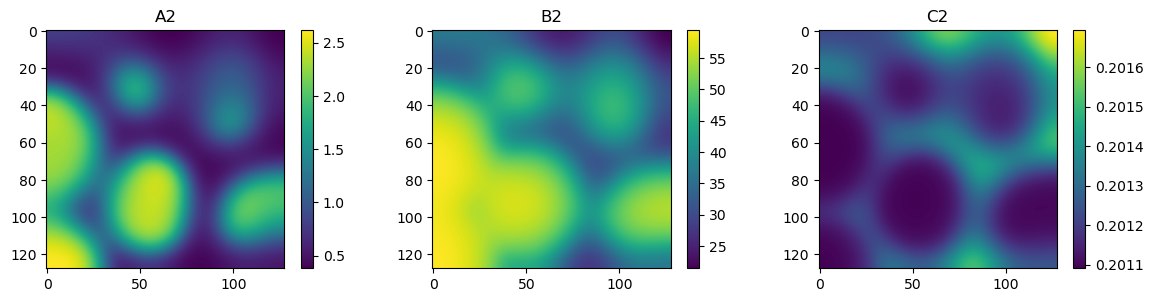

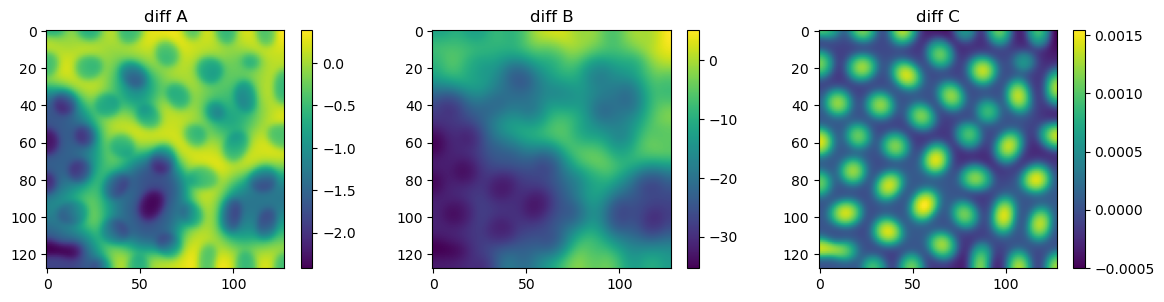

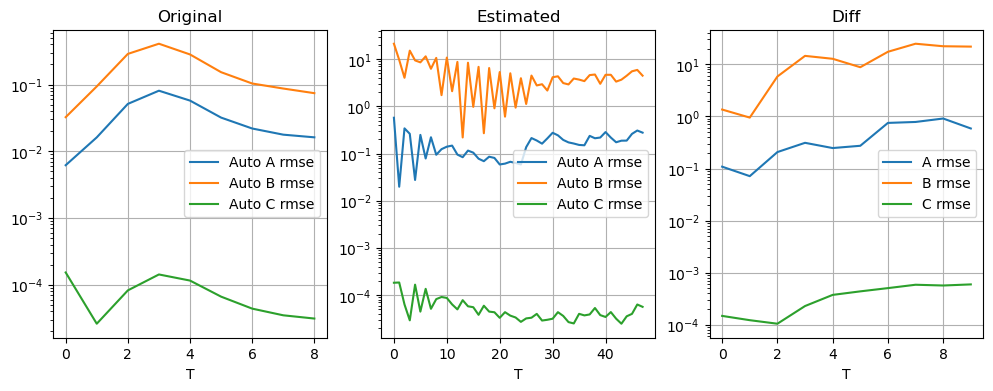

In [358]:
plot_results(73, from_start=True, noise_level=None, condition=3, hi_resolution=False, diffusion=True)

In [ ]:
params

In [285]:
params, _, _ = load_dataset("outputs_second_search/solution_10_10_84.npy")

In [ ]:
params, _, _ = load_dataset("outputs_second_search/solution_10_10_84.npy")
params

In [ ]:
for index in [0, 1, 2, 5, 9, 10, 12, 21, 23, 29, 37, 38, 39, 40, 44, 56, 62, 69, 73, 84]:
    plot_results(index, from_start=False, noise_level=None, condition=0, hi_resolution=1, diffusion=True)